# 1. A/B Testing Tools

In [1]:
from datascience import *
import numpy as np

%matplotlib inline

import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

from scipy import stats

I keep some data frames in CSV format accessible from my website. One of them is called `personality.csv` and has, as you might imagine, personality variables. In this case, we are using a subset of the personality data with variables like perfectionsism, narcissism with grouping variables like biological sex and the `AccDate` variable which has Yes/No responses to the following question:

"At a time in your life when you are not involved with anyone, a person asks you out. This person has a great personality, but you do not find this person physically attractive. Do you accept the date?"

The Stress1 and Stress2 variables are pre-post data collected from the 2nd week and 7th week of the semester respectively to see if college students experience more stress during midterms.

In [2]:
pers = Table.read_table('http://faculty.ung.edu/rsinn/perfnarc.csv')
pers

Sex,G21,Greek,AccDate,Stress1,Stress2,Perf,Narc
F,N,N,N,9,7,99,3
F,Y,N,Y,11,13,86,2
F,N,Y,N,15,14,118,4
F,N,N,Y,16,15,113,2
F,Y,N,Y,17,17,107,8
F,N,N,N,10,7,123,1
F,N,N,N,16,18,93,4
F,N,Y,Y,12,12,126,7
F,N,N,Y,11,16,91,5
F,Y,N,Y,18,16,111,1


## Tools for A/B Testing

As we walk through an example with narcissism, we will build three functions that will help us conduct A/B tests.

1. `ab_shuffle`
2. `ab_diff`
3. `ab_hist`

All three expect an input of a 2-column table with the grouping variable in the first column and a numeric variable in the second.

### Creating a 2-column table for A/B Testing

We will use the grouping variable of biological sex and numeric variable of narcissism scores.

In [3]:
narc = pers.select('Sex','Narc')

In [4]:
narc.group('Sex')

Sex,count
F,85
M,63


In [5]:
narc.group('Sex', np.average)

Sex,Narc average
F,3.81176
M,5.57143


### Calculating observed difference in means for A/B groups

In [6]:
a_mean = narc.group(0,np.average).column(1).item(0)
a_mean

3.8117647058823527

In [7]:
b_mean = narc.group(0,np.average).column(1).item(1)
b_mean

5.571428571428571

In [8]:
observed_difference = a_mean - b_mean
observed_difference

-1.7596638655462185

C:\Users\robbs\anaconda3\envs\datasci\lib\site-packages\datascience\tables.py:920: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array(tuple(values))


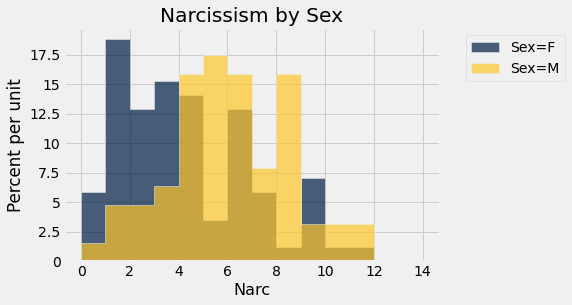

In [9]:
integer_bins = np.arange(15)
narc.hist('Narc', group = "Sex", bins = integer_bins)
_= plots.title('Narcissism by Sex')

### The A/B hypothesis test for differences in narcissism based on biological sex

The null hypothesis is that the male and female groups are drawn from the same distribution. If so, then randomly shuffling the grouping labels should not matter. The observed difference in A/B means should fall well within the distribution of shuffled differences in A/B means which we can simulate.

### Creating `ab_shuffle`: a function for shuffling the grouping labels

Let's first demonstrate step by step what we need the function to do. Then we can create the function. The first code block below demonstrates our "shuffle" command which uses the `sample` method and draws without replacement.

In [10]:
shuffle_sex = narc.sample(with_replacement = False)
shuffle_sex.show(5)

Sex,Narc
M,6
F,2
M,8
F,9
F,6


In [11]:
shuffle_sex = narc.sample(with_replacement = False).column(0)
shuffle_sex

array(['M', 'F', 'M', 'F', 'M', 'F', 'F', 'F', 'M', 'M', 'F', 'F', 'M',
       'M', 'M', 'F', 'F', 'F', 'F', 'M', 'M', 'M', 'M', 'F', 'M', 'F',
       'M', 'F', 'F', 'F', 'F', 'M', 'F', 'M', 'M', 'M', 'M', 'F', 'F',
       'F', 'M', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'M',
       'M', 'F', 'M', 'M', 'M', 'F', 'F', 'F', 'M', 'F', 'F', 'M', 'M',
       'F', 'F', 'M', 'F', 'M', 'F', 'F', 'F', 'M', 'F', 'F', 'M', 'M',
       'M', 'F', 'F', 'F', 'M', 'M', 'M', 'F', 'M', 'F', 'M', 'F', 'F',
       'M', 'M', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'M', 'F', 'M', 'M',
       'F', 'F', 'M', 'M', 'M', 'F', 'M', 'M', 'F', 'F', 'M', 'F', 'F',
       'F', 'M', 'F', 'F', 'F', 'M', 'M', 'F', 'F', 'M', 'M', 'M', 'F',
       'F', 'M', 'M', 'F', 'M', 'M', 'M', 'M', 'F', 'F', 'F', 'F', 'F',
       'F', 'F', 'M', 'F', 'F'], dtype='<U1')

After creating an array of shuffled labels, we need to include that array as column in our table. We can add the shuffled labels as a third column, then use the `select` method to create a two-column table with the columns in the correct order.

In [12]:
shuffled_narc = narc.with_column("Shuffled Grouping",shuffle_sex)
shuffled_narc.show(5)

Sex,Narc,Shuffled Grouping
F,3,M
F,2,F
F,4,M
F,2,F
F,8,M


In [13]:
shuffled_narc = narc.with_column("Shuffled Grouping",shuffle_sex).select(2,1)
shuffled_narc.show(5)

Shuffled Grouping,Narc
M,3
F,2
M,4
F,2
M,8


In [14]:
shuffled_narc.group('Shuffled Grouping',np.average)

Shuffled Grouping,Narc average
F,4.50588
M,4.63492


#### The `ab_shuffle` function

Our function just combines the previous several code blocks. Notice that the expected input is a two-column table with the grouping variable be in the first column.

In [15]:
def ab_shuffle(tab):
    shuffle_group = tab.sample(with_replacement = False).column(0)
    shuffled_tab = tab.with_column("Shuffled Grouping",shuffle_group).select(2,1)
    return shuffled_tab

ab_shuffle(narc)

Shuffled Grouping,Narc
F,3
M,2
F,4
F,2
M,8
F,1
F,4
F,7
M,5
F,1


### Creating `ab_diff`: a function that calculates the difference in A/B group means

We can add a function to the `.group` method to find the A/B group means.

In [16]:
shuffled_narc.group('Shuffled Grouping',np.average)

Shuffled Grouping,Narc average
F,4.50588
M,4.63492


In [17]:
a_mean = shuffled_narc.group('Shuffled Grouping',np.average).column(1).item(0)
a_mean

4.5058823529411764

In [18]:
b_mean = shuffled_narc.group('Shuffled Grouping',np.average).column(1).item(1)
b_mean

4.634920634920635

In [19]:
diff = a_mean - b_mean
diff

-0.12903828197945888

#### The `ab_diff` function

Using the above code blocks as a template, we can write a function that grabs the means from the grouping table. Again, the expected input is a two-column table with the grouping variable first.

In [20]:
def ab_diff(tab):
    tab.group(0,np.average)
    a_mean = tab.group(0,np.average).column(1).item(0)
    b_mean = tab.group(0,np.average).column(1).item(1)
    return a_mean - b_mean

ab_diff(shuffled_narc)

-0.12903828197945888

## Simulating the statistic

The statistic we need is the difference in shuffled A/B group means. Our plan is to use a `for` loop to repeatedly reshuffle the labels and calculate this statistic. The output will be an array representing a random sampling of this statistic.

The engine in the `for` loop is quite simple. We shuffle the data table and calculate the difference in A/B means in one line using the two functions we created above.

In [21]:
diffs = make_array()

reps = 1000

for i in range(reps):
    new_diff = ab_diff(ab_shuffle(narc))
    diffs = np.append(diffs, new_diff)

# Remove the hashtag/comment symbol to see the array output
# diffs

## Displaying the distribution of the null hypothesis statistic

Let's create a third function, one that will take an array of simulated statistics along with an observed value and plot a histogram showing both.

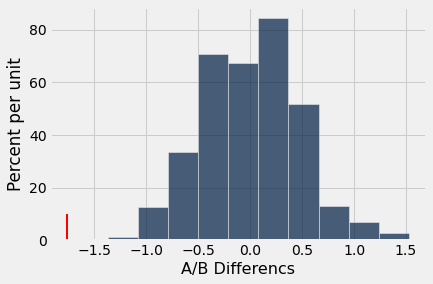

In [22]:
def ab_hist(myArray, obs_diff):
    tab = Table().with_column('A/B Differencs',myArray)
    tab.hist(0)
    _ = plots.plot([obs_diff, obs_diff], [0, 0.1], color='red', lw=2)

ab_hist(diffs,observed_difference)

Conside what the above visualization means.

1. The blue histogram represents the null hypothesis statistic
2. The red line indicates the observed value of the statistic

To calculate a $p$-value, we first creat a truth array for the number of randomized A/B differences in means that were less than the `observed_difference`. Then we can sum the truth array which counts all simulated values at least as extreme as the observed value.

In [23]:
diffs <= observed_difference

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [24]:
sum(diffs <= observed_difference)

0

In [25]:
p_val = sum(diffs <= observed_difference) / reps
p_val

0.0

## Example with perfectionism

In [26]:
perf = pers.select('Sex','Perf')
perf

Sex,Perf
F,99
F,86
F,118
F,113
F,107
F,123
F,93
F,126
F,91
F,111


In [27]:
obs_diff_perf = ab_diff(perf)
obs_diff_perf

2.5915966386554743

In [28]:
ab_shuffle(perf)

Shuffled Grouping,Perf
F,99
M,86
F,118
M,113
F,107
F,123
F,93
F,126
F,91
M,111


In [29]:
ab_diff(ab_shuffle(perf))

-2.687208216619979

In [30]:
perf_diffs = make_array()

reps = 1000

for i in range(reps):
    new_diff = ab_diff(ab_shuffle(perf))
    perf_diffs = np.append(perf_diffs, new_diff)

# perf_diffs    

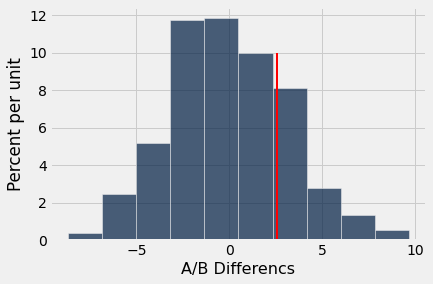

In [31]:
ab_hist(perf_diffs,obs_diff_perf)

In [32]:
p_value = sum(perf_diffs >= obs_diff_perf) / reps 
p_value

0.215